<a href="https://colab.research.google.com/github/docheem/NLP-Portfolio/blob/main/PR_dealingW_No_Labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multilabel Text classification problem

#zero-shot or few-shot learning

In this project we will be tackling a common problem facing many support teams that use issue trackers like Jira or GitHub to assist their users:

- tagging issues with metadata based on the issue’s description.
    - These tags might define the issue type, the product causing the problem, or which team is responsible for handling the reported issue.

Automating this process can have a big impact on productivity and enables the support teams to focus on helping their users. As a running example, we’ll use the GitHub issues

In [ ]:
!pip install datasets
!pip install -q transformers
!pip install -q torch
!pip install sentencepiece
!nvidia-smi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.3 MB/s eta 0:00:00
Looking in inde

In [ ]:
import time
import math
import requests
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm

def fetch_issues(owner = "huggingface",
                 repo = "transformers",
                 num_issues = 10_000,
                 rate_limit = 5_000):

    batch = []

    all_issues = []

    per_page = 100 # Number of issues to return per page

    num_pages = math.ceil(num_issues / per_page)

    base_url = "https://api.github.com/repos"

    for page in tqdm(range(num_pages)):

        # Query with state=all to get both open and closed issues
        query = f"issues?page = {page}&per_page = {per_page}&state = all"

        issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")

        batch.extend(issues.json())

        if len(batch) > rate_limit and len(all_issues) < num_issues:

            all_issues.extend(batch)

            batch = [] # Flush batch for next time period

            print(f"Reached GitHub rate limit. Sleeping for one hour ...")

            time.sleep(60 * 60 + 1)

    all_issues.extend(batch)

    df = pd.DataFrame.from_records(all_issues)

    df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

To grab all the repository’s issues, we’ll use the GitHub REST API to poll the Issues endpoint.

This endpoint returns a list of JSON objects, with each containing a large number of fields about the issue at hand, including its state (open or closed), who opened the issue, as well as the title, body, and labels.

In [ ]:
import pandas as pd



dataset_url = "https://git.io/nlp-with-transformers"

df_issues = pd.read_json(dataset_url, lines = True)

print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [ ]:
df_issues.size

258180

In [ ]:
df_issues.columns

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'body', 'performed_via_github_app',
       'pull_request'],
      dtype='object')

In [ ]:
df_issues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9930 entries, 0 to 9929
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   url                       9930 non-null   object        
 1   repository_url            9930 non-null   object        
 2   labels_url                9930 non-null   object        
 3   comments_url              9930 non-null   object        
 4   events_url                9930 non-null   object        
 5   html_url                  9930 non-null   object        
 6   id                        9930 non-null   int64         
 7   node_id                   9930 non-null   object        
 8   number                    9930 non-null   int64         
 9   title                     9930 non-null   object        
 10  user                      9930 non-null   object        
 11  labels                    9930 non-null   object        
 12  state               

There are 9930 issues in our dataset,

In [ ]:
# checking out a single row

df_issues.loc[0]

url                         https://api.github.com/repos/huggingface/trans...
repository_url              https://api.github.com/repos/huggingface/trans...
labels_url                  https://api.github.com/repos/huggingface/trans...
comments_url                https://api.github.com/repos/huggingface/trans...
events_url                  https://api.github.com/repos/huggingface/trans...
html_url                    https://github.com/huggingface/transformers/is...
id                                                                  849568459
node_id                                              MDU6SXNzdWU4NDk1Njg0NTk=
number                                                                  11046
title                       Potential incorrect application of layer norm ...
user                        {'login': 'sougata-ub', 'id': 59206549, 'node_...
labels                                                                     []
state                                                           

In [ ]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]


df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


by looking at a single row we can see that the information retrieved from the GitHub API contains many fields such as URLs, IDs, dates, users, title, body, as well as labels

In [ ]:
# overwritimng the labels column with just the label names:


df_issues["labels"] = (df_issues["labels"]
                       .apply(lambda x: [meta["name"] for meta in x]))


df_issues[["labels"]].head()


,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [ ]:
# compute the length of each row to find the number of labels per issue

df_issues["labels"].apply(lambda x :len(x)).value_counts().to_frame().T


,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


The majority of issues have zero or one label, and much fewer have more than one.

In [ ]:
# top 10 most frequent labels in the dataset
df_issues["labels"].value_counts()

[]                                                6440
[wontfix]                                         2001
[model card]                                       645
[New model]                                         56
[Core: Tokenization]                                43
                                                  ... 
[Ex: Sequence Classification, TensorFlow]            1
[PyTorch, TensorFlow]                                1
[Need more information, PyTorch, wontfix]            1
[Ex: Question Answering, Usage]                      1
[Core: Pipeline, Ex: Named Entity Recognition]       1
Name: labels, Length: 266, dtype: int64

In [ ]:
#  by “exploding” the labels column so that each label in the list becomes a row
df_counts = df_issues["labels"].explode().value_counts()

print(f"Number of unique labels: {len(df_counts)}")
print('')

df_counts.to_frame().head(8)


Number of unique labels: 65



,labels
wontfix,2284
model card,649
Core: Tokenization,106
New model,98
Core: Modeling,64
Help wanted,52
Good First Issue,50
Usage,46


The classes are very imbalanced, with wontfix and model card being the most common labels.

To make the classification problem more tractable, we’ll focus on building a tagger for a subset of the labels.

For example, some labels, such as Good First Issue or Help Wanted, are potentially very difficult to predict from the issue’s description, while others, such as model card, could be classified with a simple rule that detects when a model card is added on the Hugging Face Hub

In [ ]:
# filters the dataset for the subset of labels that we’ll work with,
# along with a standardization of the names to make them easier to read


label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}



In [ ]:
def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)

all_labels = list(label_map.values())
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [ ]:
# the distribution of the new labels

df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame()

,labels
tokenization,106
new model,98
model training,64
usage,46
pipeline,42
tensorflow or tf,41
pytorch,37
documentation,28
examples,24


In [ ]:
# new column that indicates whether the issue is unlabeled or not

df_issues["split"] = "unlabeled"

mask = df_issues["labels"].apply(lambda x: len(x)) > 0

df_issues.loc[mask, "split"] = "labeled"


df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [ ]:
# take a look at an example

for column in ["title", "body", "labels"]:

  print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [ ]:
# concatenate it with the issue’s description in the body field

df_issues["text"] = (df_issues.apply(lambda x:

                                     x["title"] +

                                     "\n\n" +

                                     x["body"],

                                     axis = 1))


df_issues["text"]

0       Potential incorrect application of layer norm ...
1       Multi-GPU seq2seq example evaluation significa...
2       [DeepSpeed] ZeRO stage 3 integration: getting ...
3       Can't load model to estimater\n\nI was trying ...
4       [LXMERT] Unclear what img_tensorize does with ...
                              ...                        
9925    DistilBERT\n\nPreparing the release for Distil...
9926    Bert initialization\n\nWhen I train bert model...
9927    UnicodeDecodeError: 'charmap' codec can't deco...
9928    XLNet resize embedding size ERROR\n\n## ❓ Ques...
9929    Extracting Features Example\n\n## ❓ Questions ...
Name: text, Length: 9930, dtype: object

In [ ]:
# check for any duplicates in the data and drop them with the drop_duplicates() method

len_before = len(df_issues)

df_issues = df_issues.drop_duplicates(subset="text")


print(f"Removed {(len_before - len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


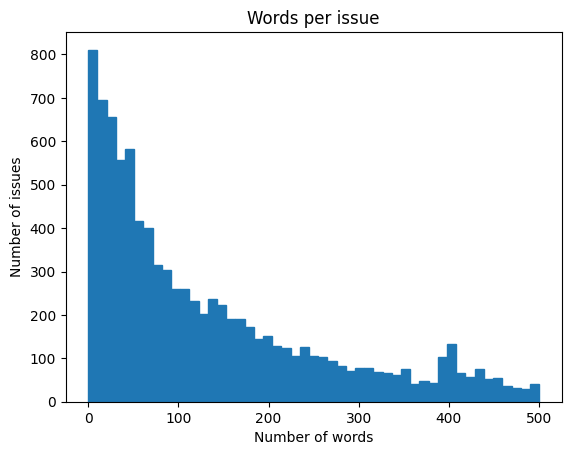

In [ ]:
# looking at the number of words in our texts to see
# if we’ll lose much information when we truncate
# to each model’s context size

import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len).hist(bins = np.linspace(0, 500, 50),
                                               grid = False,
                                               edgecolor = "C0"))

plt.title("Words per issue")

plt.xlabel("Number of words")
plt.ylabel("Number of issues")


plt.show()


The distribution has the long tail characteristic of many text datasets. Most of the texts are fairly short, but there are also issues with more than 500 words. It is common to have some very long issues, especially when error messages and code snippets are posted along with them.

#Creating Training Sets

We will be Defining our training and validation sets to benchmark our classifiers.

In [ ]:
#def filter_labels(x):
    #return [label_map[label] for label in x if label in label_map]

#df_issues["labels"] = df_issues["labels"].apply(filter_labels)

#all_labels = list(label_map.values())

In [ ]:
# Transform our set of labels, like pytorch and tokenization,
# into a format that the model can process.

from sklearn.preprocessing import MultiLabelBinarizer


mlb = MultiLabelBinarizer()

mlb.fit([all_labels])


mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 3.5 MB/s eta 0:00:00


In [ ]:
# creates the train/test splits iteratively to achieve balanced labels

from skmultilearn.model_selection import iterative_train_test_split



def balanced_split(df, test_size = 0.5):

    ind = np.expand_dims(np.arange(len(df)),
                         axis=1)

    labels = mlb.transform(df["labels"])

    ind_train, _, ind_test, _ = iterative_train_test_split(ind,

                                                           labels,

                                                           test_size)


    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [ ]:
# splitting the data

from sklearn.model_selection import train_test_split



df_clean = df_issues[["text",
                      "labels",
                      "split"]].reset_index(drop = True).copy()


df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]

df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]


np.random.seed(0)


df_train, df_tmp = balanced_split(df_sup, test_size=0.5)

df_valid, df_test = balanced_split(df_tmp, test_size = 0.5)

In [ ]:
# Creating a DatasetDict with all the splits so that we can easily tokenize the dataset and integrate with the Trainer

from datasets import Dataset, DatasetDict


ds = DatasetDict({"train": Dataset.from_pandas(df_train.reset_index(drop = True)),

                  "valid": Dataset.from_pandas(df_valid.reset_index(drop = True)),

                  "test": Dataset.from_pandas(df_test.reset_index(drop = True)),

                  "unsup": Dataset.from_pandas(df_unsup.reset_index(drop = True))})

Creating Training Slices

In [ ]:
# Creating Training Slices


np.random.seed(0)

all_indices = np.expand_dims(list(range(len(ds["train"]))), axis = 1)

indices_pool = all_indices

labels = mlb.transform(ds["train"]["labels"])

train_samples = [8, 16, 32, 64, 128]

train_slices, last_k = [], 0


for i, k in enumerate(train_samples):

    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(indices_pool,
                                                                    labels,
                                                                    (k-last_k)/len(labels))
    last_k = k

    if i==0: train_slices.append(new_slice)

    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))


# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))

train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [ ]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


we’ve finally prepared our dataset into training splits.

#Implementing a Naive Bayesline

In [ ]:
# using a multilabel binarizer to create a new label_ids column in our training sets

def prepare_labels(batch):

  batch["label_ids"] = mlb.transform(batch["labels"])

  return batch

ds = ds.map(prepare_labels,
            batched = True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

To measure the performance of our classifiers, we’ll use the micro and macro F1-scores, where the former tracks performance on the frequent labels and the latter on all labels disregarding the frequency

In [ ]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer


for train_slice in train_slices:

    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)

    y_train = np.array(ds_train_sample["label_ids"])

    y_test = np.array(ds["test"]["label_ids"])


    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()

    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])

    X_test_counts = count_vect.transform(ds["test"]["text"])


    # Create and train our model!
    classifier = BinaryRelevance(classifier = MultinomialNB())

    classifier.fit(X_train_counts, y_train)



    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)

    clf_report = classification_report(y_test,

                                       y_pred_test,

                                       target_names = mlb.classes_,

                                       zero_division=0,

                                       output_dict = True)


    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])

    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])


In [ ]:
#  plotting the results

import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)


    for run in micro_scores.keys():

        if run == current_model:

            ax0.plot(sample_sizes,

                     micro_scores[run],

                     label = run,

                     linewidth = 2)

            ax1.plot(sample_sizes,

                     macro_scores[run],

                     label = run,

                     linewidth = 2)
        else:
            ax0.plot(sample_sizes,

                     micro_scores[run],

                     label=run,

                     linestyle="dashed")


            ax1.plot(sample_sizes,

                     macro_scores[run],

                     label=run,

                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")

    ax0.set_ylabel("Test set F1 score")

    ax0.legend(loc="lower right")

    for ax in [ax0, ax1]:

        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")

        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)

        ax.minorticks_off()

    plt.tight_layout()


    plt.show()


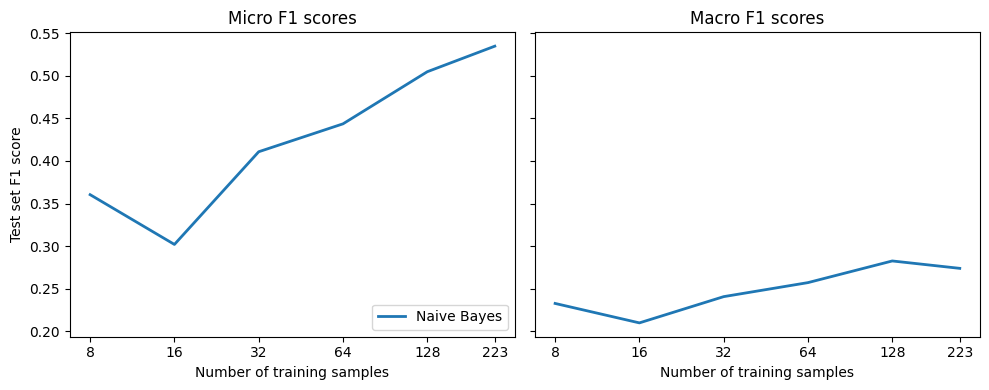

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

Note that we plot the number of samples on a logarithmic scale. From the figure we can see that the micro and macro F1-scores both improve as we increase the number of training samples.

With so few samples to train on, the results are also slightly noisy since each slice can have a different class distribution.

# Zero-Shot Classification
Working with No Labeled Data

The goal of zero-shot classification is to make use of a pretrained model without any additional fine-tuning on your task-specific corpus.

In [ ]:
from transformers import pipeline

pipe = pipeline("fill-mask",
                model = "bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# zero-shot with bert

movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "



prompt = "The movie is about [MASK]."


output = pipe(movie_desc + prompt)


for element in output:

    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")


Token animals:	0.103%
Token lions:	0.066%
Token birds:	0.025%
Token love:	0.015%
Token hunting:	0.013%


Bert model predicts only tokens that are related to animals.

instead of getting the most likely tokens we can query the pipeline for the probability of a few given tokens

In [ ]:
# query the pipeline for the probability of a few given tokens

output = pipe(movie_desc +
              prompt,
              targets = ["animals", "cars"])

for element in output:

    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")


Token animals:	0.103%
Token cars:	0.001%


the predicted probability for the token cars is much smaller than for
animals.

In [ ]:
# for a description that is closer to cars

movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc +
              prompt,
              targets = ["animals", "cars"])

for element in output:

    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")


Token cars:	0.139%
Token animals:	0.006%


Natural language inference (NLI)

Model that has been trained on a task that is closer to .

There is a neat proxy task called text entailment that fits the bill. In text entailment, the model needs to determine whether two text passages are likely to follow or contradict each other.

In [ ]:
# Multi-Genre NLI Corpus (MNLI) / Cross-Lingual NLI Corpus (XNLI) from transformers

from transformers import pipeline

pipe = pipeline("zero-shot-classification",

                device = 0) # makes sure that the model runs on the GPU.

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# classifying a text

sample = ds["train"][0]

print(f"Labels: {sample['labels']}")


output = pipe(sample["text"],

              all_labels,

              multi_label = True)


print(output["sequence"][:400])

print("\nPredictions:")


for label, score in zip(output["labels"],

                        output["scores"]):

    print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [ ]:
# feeding a single example through the zero-shot pipeline,
# and then scale it out to the whole validation set by running map()

def zero_shot_pipeline(example):

    output = pipe(example["text"],

                  all_labels,

                  multi_label = True)


    example["predicted_labels"] = output["labels"]

    example["scores"] = output["scores"]

    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Determining which set of labels should be assigned to each example, we will:

- Define a threshold and select all labels above the threshold

- Pick the top k labels with the k highest scores

In [ ]:
# get_preds() function that applies one of the approaches to retrieve the predictions

def get_preds(example, threshold = None, topk = None):

    preds = []

    if threshold:

        for label, score in zip(example["predicted_labels"],
                                example["scores"]):

            if score >= threshold:
                preds.append(label)
    elif topk:

        for i in range(topk):

            preds.append(example["predicted_labels"][i])
    else:

        raise ValueError("Set either `threshold` or `topk`.")

    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}



In [ ]:
# get_clf_report(), that returns the Scikit-learn classification report
# from a dataset with the predicted labels

def get_clf_report(ds):

    y_true = np.array(ds["label_ids"])

    y_pred = np.array(ds["pred_label_ids"])

    return classification_report(y_true,

                                 y_pred,

                                 target_names = mlb.classes_,

                                 zero_division=0,

                                 output_dict=True)


Let’s start with the top-k method by increasing k for several values and then plotting the micro and macro F1-scores across the validation set

In [ ]:
# top-k method

macros, micros = [], []

topks = [1, 2, 3, 4]

for topk in topks:

    ds_zero_shot = ds_zero_shot.map(get_preds,

                                    batched = False,

                                    fn_kwargs = {'topk': topk})

    clf_report = get_clf_report(ds_zero_shot)

    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

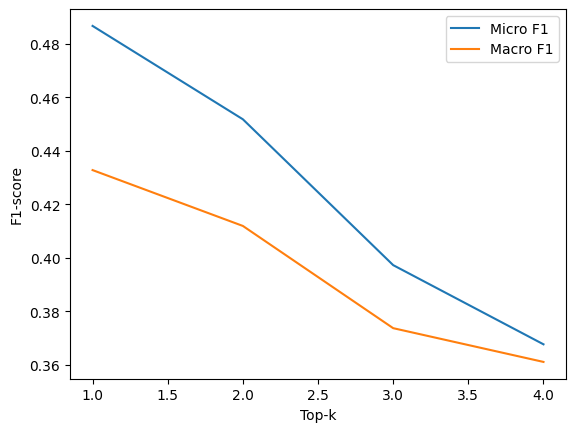

In [ ]:
#plotting top-k

plt.plot(topks,

         micros,

         label = 'Micro F1')


plt.plot(topks,

         macros,

         label = 'Macro F1')


plt.xlabel("Top-k")

plt.ylabel("F1-score")
plt.legend(loc='best')

plt.show()


From the plot we can see that the best results are obtained by selecting the label with the highest score per example (top 1).

Let’s now compare this against setting a threshold, so we can potentially predict more than one label per example:

In [ ]:
# Comparing above results against setting a threshold

macros, micros = [], []

thresholds = np.linspace(0.01, 1, 100)

for threshold in thresholds:

    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs = {"threshold": threshold})

    clf_report = get_clf_report(ds_zero_shot)

    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

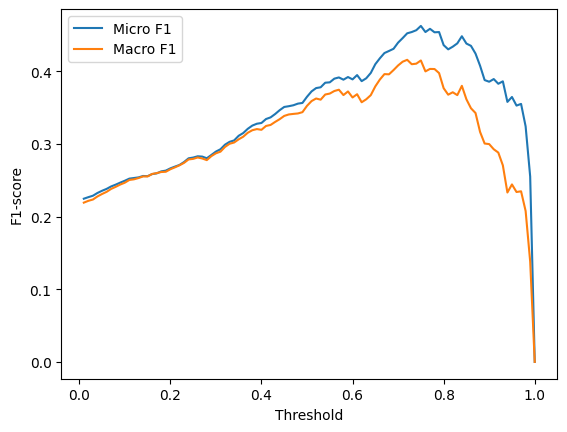

In [ ]:
plt.plot(thresholds,

         micros,

         label = "Micro F1")

plt.plot(thresholds,

         macros,

         label = "Macro F1")

plt.xlabel("Threshold")

plt.ylabel("F1-score")

plt.legend(loc="best")


plt.show()

In [ ]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)

print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')

best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)

print(f'Best threshold (micro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (micro): 0.72 with F1-score 0.42.


From the plot we can see that a threshold value of around 0.8 is the sweet spot between the two.

Since the top-1 method performs best, let’s use this to compare zero-shot classification against Naive Bayes on the test set


In [ ]:
# Zero-shot classification against Naive Bayes

ds_zero_shot = ds['test'].map(zero_shot_pipeline)

ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})

clf_report = get_clf_report(ds_zero_shot)

for train_slice in train_slices:

    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

/usr/local/lib/python3.9/dist-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

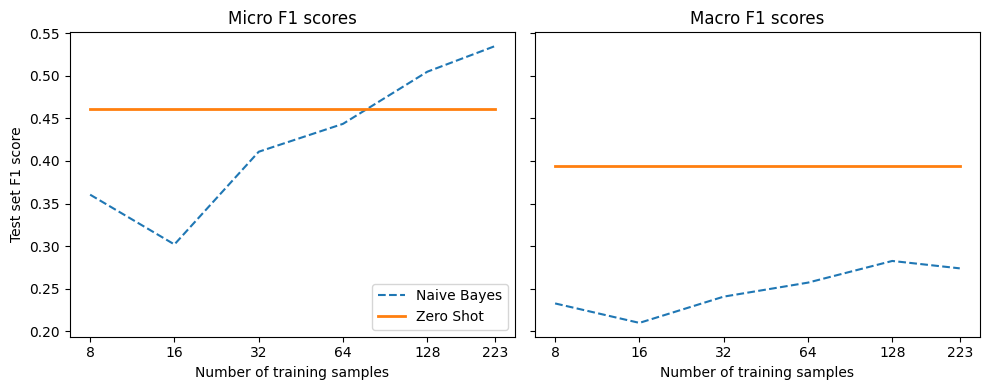

In [ ]:
plot_metrics(micro_scores,

             macro_scores,

             train_samples, "Zero Shot")

The results for the micro F1-score tell us that the baseline performs well on the frequent classes, while the zero-shot pipeline excels at those since it does not require any examples to learn from.

#Working with a Few Labels

One simple but effective way to boost the performance of text classifiers on small datasets is to apply data augmentation techniques to generate new training examples from the existing ones.  

We’ll focus on using synonym replacement using  NlpAug and TextAttack libraries.

In [ ]:
! pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 KB 7.5 MB/s eta 0:00:00


In [ ]:
!pip install sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=63b459b5e90ca76c3e704bbf799fcd3107a2cb26a916c0421799977c6e3ba03c
  Stored in directory: /root/.cache/pip/wheels/12/1c/3d/46cf06718d63a32ff798a89594b61e7f345ab6b36d909ce033
Successfully built sacremoses


In [ ]:
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
set_seed(3)

text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"

augs = {}

augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet')

augs["random_insert"] = naw.ContextualWordEmbsAug(model_path = "distilbert-base-uncased",
                                                  device = "cpu",
                                                  action = "insert",
                                                  aug_max = 1)

augs["random_swap"] = naw.RandomWordAug(action="swap")

augs["random_delete"] = naw.RandomWordAug()

augs["bt_en_de"] = naw.BackTranslationAug(from_model_name = 'facebook/wmt19-en-de',
                                          to_model_name='facebook/wmt19-de-en')
for k,v in augs.items():
    print(f"Original text: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")


Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
synonym_replace: ['Even if you vote down me Megatron, others will turn out to defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_insert: ['even if you defeat me megatron, others will rise to ultimately defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_swap: ['Even if you defeat Megatron me, others to will rise defeat your tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_delete: ['Even if me Megatron, will rise to tyranny']

Original text: Even if you defeat me Megatron, others will rise to defeat your tyranny
bt_en_de: ['Even if you defeat me, others will rise up to defeat your tyranny']



In [ ]:
from transformers import set_seed
import nlpaug.augmenter.word as naw



set_seed(3)

aug = naw.ContextualWordEmbsAug(model_path = "distilbert-base-uncased",

                                device = "cpu",

                                action="substitute")


text = "Transformers are the most popular toys"

print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")


Original text: Transformers are the most popular toys
Augmented text: ['transformers — the most coveted toys']


We can see how the word “are” has been replaced with an apostrophe to generate a new synthetic training example.

In [ ]:
import random
import numpy as np

def augment_text(batch, transformations_per_example = 2):

    text = batch["text"]

    label_ids = []

    text_aug = []


    for i in range(len(text)):

        for j in range(transformations_per_example):

            # apply an augmentation transformation
            augmented_text = text[i]

            text_aug.append(str(augmented_text))

            label_ids += [batch["label_ids"][i]]

    return {"text": text_aug, "label_ids": np.array(label_ids)}


In [ ]:
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
for train_slice in train_slices:

    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)

    # Flatten augmentations and align labels!
    ds_train_aug = (ds_train_sample.map(augment_text,

                                        batched = True,

                                        remove_columns = ds_train_sample.column_names).shuffle(seed=42))


    y_train = np.array(ds_train_aug["label_ids"])

    y_test = np.array(ds["test"]["label_ids"])


    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()

    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])

    X_test_counts = count_vect.transform(ds["test"]["text"])


    # Create and train our model!
    classifier = BinaryRelevance(classifier = MultinomialNB())

    classifier.fit(X_train_counts, y_train)

    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)

    clf_report = classification_report(y_test,

                                       y_pred_test,

                                       target_names = mlb.classes_,

                                       zero_division=0,
        output_dict=True)

    # Store metrics
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

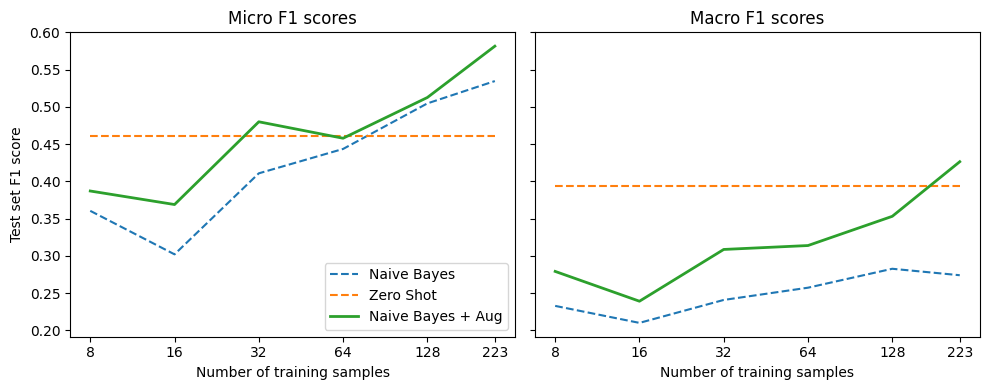

In [ ]:
plot_metrics(micro_scores,

             macro_scores,

             train_samples,

             "Naive Bayes + Aug")

We can see that a small amount of data augmentation improves the F1-score of the Naive Bayes classifier by around 5 points, and it overtakes the zero- shot pipeline for the macro scores once we have around 170 training samples.

#Using Embeddings as a Lookup Table with GPT-2

The embeddings of large language models can be used to develop a semantic search engine, find similar documents or comments, or even classify text.


We’ll create a text classifier that’s modeled after the OpenAI API classification endpoint. The idea follows a three-step process:
- Use the language model to embed all labeled texts.
- Perform a nearest neighbor search over the stored embeddings.
- Aggregate the labels of the nearest neighbors to get a prediction.

GPT-2 will actually return one embedding vector per token. we really want is a single embed‐ ding vector for the whole sentence (or GitHub issue in our application).

To deal with this, we can use a technique called pooling.

In [ ]:
# defining the mean pooling operation

import torch
from transformers import AutoTokenizer, AutoModel


model_ckpt = "miguelvictor/python-gpt2-large"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model = AutoModel.from_pretrained(model_ckpt)


def mean_pooling(model_output, attention_mask):

    # Extract the token embeddings
    token_embeddings = model_output[0]

    # Compute the attention mask
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())

    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)

    sum_mask = torch.clamp(input_mask_expanded.sum(1), min = 1e-9)

    # Return the average as a single vector
    return sum_embeddings / sum_mask


def embed_text(examples):
    inputs = tokenizer(examples["text"],

                       padding = True,

                       truncation = True,

                       max_length = 128,

                       return_tensors = "pt")


    with torch.no_grad():

        model_output = model(**inputs)


    pooled_embeds = mean_pooling(model_output,

                                 inputs["attention_mask"])


    return {"embedding": pooled_embeds.cpu().numpy()}

Some weights of the model checkpoint at miguelvictor/python-gpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Note that GPT-style models don’t have a padding token, and therefore we need to add one before we can get the  in a batched fashion as implemented in the preceding code.

In [ ]:
#adding padding token to get embedding
tokenizer.pad_token = tokenizer.eos_token


# get the embeddings for each split
embs_train = ds["train"].map(embed_text,

                             batched = True,

                             batch_size = 16)


embs_valid = ds["valid"].map(embed_text,

                             batched = True,

                             batch_size = 16)


embs_test = ds["test"].map(embed_text,

                           batched = True,

                           batch_size = 16)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

In [ ]:
!pip install faiss-gpu
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# set up a system to search embeddings
# use a built-in structure of huggingface Datasets
# called a FAISS index

import faiss


embs_train.add_faiss_index("embedding")

In [ ]:
# perform a nearest neighbor lookup by calling the function get_nearest_examples()

# Select the first query and 3 nearest neighbors
i, k = 0, 3

# Used to remove newlines in text for compact display
rn, nl = "\r\n\r\n", "\n"

#specifying the query embedding
query =  np.array(embs_valid[i]["embedding"],

                  dtype = np.float32)

# matching score for each neighbor.
scores, samples = embs_train.get_nearest_examples("embedding",

                                                  query,

                                                  k = k)


print(f"QUERY LABELS: {embs_valid[i]['labels']}")

print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")


print("="*50)

print(f"Retrieved documents:")

for score, label, text in zip(scores,

                              samples["labels"],

                              samples["text"]):
    print("="*50)

    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")

    print(f"SCORE: {score:.2f}")

    print(f"LABELS: {label}")

The three retrieved documents that we got via embedding lookup all have the same labels and we can already see from the titles that they are all very similar.

 The query as well as the retrieved documents revolve around adding new and efficient transformer models.

Finding the best value for k

how we should then aggregate the labels of the retrieved documents? Should we, for example, retrieve three documents and assign all labels that occurred at least twice? Or should we go for 20 and use all labels that appeared at least 5 times?

In [ ]:
# function get_nearest_examples_batch(), which accepts a batch of queries:

def get_sample_preds(sample, m):

    return (np.sum(sample["label_ids"],

                   axis=0) >= m).astype(int)


def find_best_k_m(ds_train, valid_queries,
                  valid_labels, max_k = 17):

    max_k = min(len(ds_train), max_k)

    perf_micro = np.zeros((max_k, max_k))

    perf_macro = np.zeros((max_k, max_k))


    for k in range(1, max_k):

        for m in range(1, k + 1):

            _, samples = ds_train.get_nearest_examples_batch("embedding",

                                                             valid_queries,

                                                             k = k)

            y_pred = np.array([get_sample_preds(s, m) for s in samples])

            clf_report = classification_report(valid_labels,

                                               y_pred,

                                               target_names = mlb.classes_,

                                               zero_division = 0,

                                               output_dict = True)


            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]

            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]

    return perf_micro, perf_macro



In [ ]:
# check what the best values would be with all the training samples

valid_labels = np.array(embs_valid["label_ids"])

valid_queries = np.array(embs_valid["embedding"], dtype = np.float32)


perf_micro, perf_macro = find_best_k_m(embs_train,

                                       valid_queries,

                                       valid_labels)

In [ ]:
# visualize the scores for all k and m configurations

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey = True)

ax0.imshow(perf_micro)

ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")

for ax in [ax0, ax1]:

    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")

plt.show()


In [ ]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)

print(f"Best k: {k}, best m: {m}")

The perfomance is best when we choose k = 15 and m = 5, or in other words when we retrieve the 15 nearest neighbors and then assign the labels that occurred at least 5 times.

Going through the slices of the training set and evaluate the performance with the Naive Bayes classifier.

In [ ]:
# Before we can slice the dataset, we need to remove the index
# we cannot slice a FAISS index like the dataset


# removing the index
embs_train.drop_index("embedding")


test_labels = np.array(embs_test["label_ids"])

test_queries = np.array(embs_test["embedding"],

                        dtype = np.float32)

for train_slice in train_slices:

    # Create a FAISS index from training slice
    embs_train_tmp = embs_train.select(train_slice)

    embs_train_tmp.add_faiss_index("embedding")

    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp,

                                  valid_queries,

                                  valid_labels)


    k, m = np.unravel_index(perf_micro.argmax(),

                            perf_micro.shape)

    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",

                                                           test_queries,

                                                           k = int(k))

    y_pred = np.array([get_sample_preds(s, m) for s in samples])

    # Evaluate predictions
    clf_report = classification_report(test_labels,

                                       y_pred,

                                       target_names = mlb.classes_,

                                       zero_division = 0,

                                       output_dict = True)


    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])

    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])


In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

# Fine-Tuning a Vanilla Transformer

If we have access to labeled data, we can also try to do the obvious thing: simply fine- tune a pretrained transformer model. In this section, we’ll use the standard BERT checkpoint as a starting point.

In [ ]:
#hide_output
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)


model_ckpt = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


def tokenize(batch):

    return tokenizer(batch["text"],

                     truncation = True,

                     max_length=128)


ds_enc = ds.map(tokenize, batched = True)

ds_enc = ds_enc.remove_columns(['labels', 'text'])


The multilabel loss function expects the labels to be of type float.  Therefore, we need to change the type of the column label_ids to a different format.

First, we create a new column with the labels. The format of that column is inferred from the first element. Then we delete the original column and rename the new one to take the place of the original one

In [ ]:
# formatting for multi-label recognitions

ds_enc.set_format("torch")

ds_enc = ds_enc.map(lambda x: {"label_ids_f":

                               x["label_ids"].to(torch.float)},

                    remove_columns = ["label_ids"])


ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

We are likely to quickly overfit the training data due to its limited size, we set load_best_model_at_end=True and choose the best model based on the micro F1-score

In [ ]:
from transformers import Trainer, TrainingArguments


training_args_fine_tune = TrainingArguments(output_dir="./results",

                                            num_train_epochs = 20,

                                            learning_rate = 3e-5,

                                            lr_scheduler_type = 'constant',

                                            per_device_train_batch_size = 4,

                                            per_device_eval_batch_size = 32,

                                            weight_decay = 0.0,

                                            evaluation_strategy = "epoch",

                                            save_strategy = "epoch",

                                            logging_strategy = "epoch",

                                            load_best_model_at_end = True,

                                            metric_for_best_model = 'micro f1',

                                            save_total_limit = 1,

                                            log_level = 'error')


We first need to normalize the predictions with a sigmoid function and can then binarize them with a simple threshold. Then we return the scores we are interested in from the classifica‐ tion report:

In [ ]:
from scipy.special import expit as sigmoid


def compute_metrics(pred):

    y_true = pred.label_ids

    y_pred = sigmoid(pred.predictions)

    y_pred = (y_pred>0.5).astype(float)


    clf_dict = classification_report(y_true,

                                     y_pred,

                                     target_names = all_labels,

                                     zero_division = 0,

                                     output_dict=True)


    return {"micro f1": clf_dict["micro avg"]["f1-score"],

            "macro f1": clf_dict["macro avg"]["f1-score"]}

For each training set slice we train a classifier from scratch, load the best model at the end of the training loop, and store the results on the test set

In [ ]:
config = AutoConfig.from_pretrained(model_ckpt)

config.num_labels = len(all_labels)

config.problem_type = "multi_label_classification"

In [ ]:
for train_slice in train_slices:

    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,

                                                               config = config)
    trainer = Trainer(model = model,

                      tokenizer = tokenizer,

                      args = training_args_fine_tune,

                      compute_metrics = compute_metrics,

                      train_dataset = ds_enc["train"].select(train_slice),

                      eval_dataset = ds_enc["valid"])


    trainer.train()


    pred = trainer.predict(ds_enc["test"])

    metrics = compute_metrics(pred)


    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])

    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

In [ ]:
plot_metrics(micro_scores,

             macro_scores,

             train_samples, "Fine-tune (vanilla)")

#Fine-Tuning a Language Model

We’ll fine-tune the pretrained BERT model with masked language modeling on the unlabeled portion of our dataset

In [ ]:
def tokenize(batch):

    return tokenizer(batch["text"],

                     truncation = True,

                     max_length = 128,

                     return_special_tokens_mask = True)


ds_mlm = ds.map(tokenize,

                batched = True)


ds_mlm = ds_mlm.remove_columns(["labels",

                                "text",

                                "label_ids"])

In [ ]:
# using a special data collator called DataCollatorForLanguageModeling.
# We tell it to cover up 15% of the words

from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer,
                                                mlm_probability = 0.15)


In [ ]:
set_seed(3)

data_collator.return_tensors = "np"

inputs = tokenizer("Transformers are awesome!",

                   return_tensors="np")


outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])


original_input_ids = inputs["input_ids"][0]

masked_input_ids = outputs["input_ids"][0]


pd.DataFrame({"Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),

              "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),

              "Original input_ids": original_input_ids,

              "Masked input_ids": masked_input_ids,

              "Labels": outputs["labels"][0]}).T

The token corresponding to the exclamation mark has been replaced with a mask token. In addition, the data collator returned a label array, which is –100 for the original tokens and the token ID for the masked tokens.

In [ ]:
# switch the format of the data collator back to PyTorch

data_collator.return_tensors = "pt"

We set up the TrainingArguments and Trainer as usual

In [ ]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(output_dir = f"{model_ckpt}-issues-128",

                                  per_device_train_batch_size = 32,

                                  logging_strategy = "epoch",

                                  evaluation_strategy = "epoch",

                                  save_strategy = "no",

                                  num_train_epochs = 16,

                                  push_to_hub = True,

                                  log_level = "error",

                                  report_to = "none")



In [ ]:
trainer = Trainer( model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),

                  tokenizer = tokenizer,

                  args = training_args,

                  data_collator = data_collator,

                  train_dataset = ds_mlm["unsup"],

                  eval_dataset = ds_mlm["train"])

trainer.train()

In [ ]:
trainer.push_to_hub("Training complete!")

We can access the trainer’s log history to look at the training and validation losses of the model.

All logs are stored in trainer.state.log_history as a list of dictionaries that we can easily load into a Pandas DataFrame.

 Since the training and validation loss are recorded at different steps, there are missing values in the dataframe.

 For this reason we drop the missing values before plotting the metrics

In [ ]:

df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

It seems that both the training and validation loss went down considerably. So let’s check if we can also see an improvement when we fine-tune a classifier based on this model

# Fine-Tuning a Classifier

In [ ]:
# we load our own custom checkpoint:

model_ckpt = f'{model_ckpt}-issues-128'

config = AutoConfig.from_pretrained(model_ckpt)

config.num_labels = len(all_labels)

config.problem_type = "multi_label_classification"



In [ ]:
# Fine-tuning

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,

                                                               config = config)
    trainer = Trainer(model = model,

                      tokenizer = tokenizer,

                      args = training_args_fine_tune,

                      compute_metrics = compute_metrics,

                      train_dataset = ds_enc["train"].select(train_slice),

                      eval_dataset=ds_enc["valid"])

    trainer.train()

    pred = trainer.predict(ds_enc['test'])

    metrics = compute_metrics(pred)

    # DA refers to domain adaptation
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])

    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

Comparing the results to the fine-tuning based on vanilla BERT, we see that we get an advantage especially in the low-data domain. We also gain a few percentage points in the regime where more labeled data is available

In [ ]:
plot_metrics(micro_scores,

             macro_scores,

             train_samples,

             "Fine-tune (DA)")

This highlights that domain adaptation can provide a slight boost to the model’s per‐ formance with unlabeled data and little effort. Naturally, the more unlabeled data and the less labeled data you have, the more impact you will get with this method.